In [1]:
#Import libraries
import seaborn as sns
import os, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats
import itertools
from statannotations.Annotator import Annotator
from scipy.interpolate import UnivariateSpline


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, font_scale = 1.5)
sns.set_style('white')

Import all data

In [2]:
#Main project directory
base_dir = 'C:/Users/shenlab/Box/Amy Rohlfing DPA paper/'

#Output figure path
figdir = os.path.join(base_dir,'Updated Figures')
#Import OD drop data
od_bufferdat = pd.read_csv(os.path.join(base_dir,'Compiled datasets','220929_OD_drop_96well_buffer_formatteddat.csv'))

# #Import already processed data
filenames = ['cortex_mutants_all.csv', '10mM_Gly_30mM_Ca_all.csv', 'dpa_supernatant_all.csv']
filenames_rt = ['cortex_mutants_all_rt.csv', '10mM_Gly_30mM_Ca_all_rt.csv', 'dpa_supernatant_all_rt.csv']

cortexdat, glydat, supdat = [pd.read_csv(os.path.join(base_dir, 'Compiled datasets',file)) for file in filenames]
cortexda_rt, glydat_rt, supdat_rt = [pd.read_csv(os.path.join(base_dir, 'Compiled datasets', file)) for file in filenames_rt]

True


In [3]:
#Import useful functions
#Useful functions for data processing 
def new_identifier(df):
    #function assigns new identifiers to all cells in dataframe. Runs slow but works. Need to vectorize this operation to take advantage of the pandas API.
    df['unique_id'] = np.nan
    groups = df.groupby(['Strain', 'Replicate', 'Position', 'Condition', 'ID'])['ID'].count()
    df = df.set_index(['Strain', 'Replicate', 'Position', 'Condition', 'ID']).sort_index()
    
    for i,index in enumerate(groups.index):
        df['unique_id'].loc[index] = int(i)
    
    df.reset_index(inplace=True)
    return df


def get_int_ratio(df, feature_key='mean_intensity'):
    #find first and last time of trace
    t_0 = df.Time.min()
    t_end = df.Time.max()

    #get first and last intensity, indexed by time
    int_0 = df.mean_intensity.loc[df.Time==t_0].to_numpy()
    int_end = df.mean_intensity.loc[df.Time==t_end].to_numpy()
    
    #Take the ratio of intensities and return as a float
    ratio = int_0/int_end
    
    return ratio.astype(np.float64)[0]



#Sort data and assign colors for plotting
def sort_plot_data(df, order, key = 'Condition'):
    #Function converts conditions as a categorical variable in pandas and allows us to specify a specific order to them as opposed to ordering based alphabetically.
    df[key] = df[key].astype(order)
    return df.sort_values(key, ascending=False)

def super_violins(df,x,y,hue,colors, size=(15,10), dpi=300, dodge=False, fig = None, gridspec=None, width = None, stat='mean'):
    """Plots a superplot violin. Parameters are input dataframe, xdata, ydata, hue to define groups and a color dictionary for each strain"""
    #Get medians for replicate od_bufferdat
    summstat = df.groupby(['Strain', 'Replicate', 'Condition'])[y].agg(['median', 'mean', 'count']).reset_index()
    if (fig != None) & (gridspec!= None):
        ax = fig.add_subplot(gridspec)
    else:
        fig, ax = plt.subplots(figsize=size, dpi=dpi)
        
    sns.violinplot(y=y, 
                x=x,
                hue=hue,
                data=df,
                inner=None,
                linewidth=5,
                dodge=dodge,
                palette=['white']*100,
                ax=ax,
                width=width)

    sns.stripplot(y=y, 
                x=x,
                hue=hue, 
                data=df,
                edgecolor=None,
                size=6, 
                dodge=dodge,
                alpha=0.5,
                palette=colors,
                ax=ax)

    for violin in ax.collections:
        violin.set_edgecolor('lightgray')

    sns.swarmplot(y=stat, 
                x=x,
                hue=hue, 
                data=summstat,
                palette={group: 'darkblue' for group in summstat[hue].unique()},
                size=14, 
                dodge=dodge,
                ax=ax)

    sns.pointplot(y=stat, 
                x=x,
                hue=hue, 
                data=summstat,
                estimator=np.mean,
                errorbar='se',
                errwidth=3,
                dodge=dodge,
                join=False,
                palette={group: 'darkslategray' for group in summstat[hue].unique()},
                markers='D',
                capsize=0.1,
                scale=1.5,
                ax=ax)


    #Bring pointplot to the top
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    hands, labs = ax.get_legend_handles_labels()
    sns.set_style("whitegrid", {'axes.grid' : False})
    return summstat, ax

def get_cv(data):
    return np.std(data, ddof=1) / np.mean(data) * 100

def remove_noisy(df, cv_threshold, noise_count = 5):
    '''Funciton removes bad traces based CVs calculated at multiple windows throughout the od_bufferdat. 
    Inputs: dataframe, cv_threshold is CV value set as threshold to discard bad data, noise_count is the number of times that thereshold
    is exceeded in the od_bufferdat.
    Function may be slow on very large datasets. Could use further optimiazation.'''
    #Remove IDs with more than x number of noisy datapoints based on CV at different windows along the timeseries.
    bad_traces = []
    for id in df.unique_id.unique():
        count = df.loc[(df.unique_id == id) & (df.CV > cv_threshold)].shape[0]
        if count > noise_count:
            bad_traces.append(id)

    clean = df[~df['unique_id'].isin(bad_traces)]
    return clean, bad_traces

def get_int_change(df):
    #Use expanding window to find the intensity change over time from the starting intensity
    changeint = df.groupby(['unique_id'])['mean_intensity'].expanding(1).apply(lambda x: x.iloc[-1]/x.iloc[0]).reset_index(name='intensity_change')
    #add column to dataset
    df['intensity_change'] = changeint.intensity_change
    return df

def fit_spline(df, feature_key='intensity_change', smoothing_factor = 0.02, ret_smoothed=False):
    '''Fits univariate spline to germination od_bufferdat. Driverivatives provide info on rate and the data is smoothed to mitigate noise.
    Input, dataframe'''
    xdata = df.Time.to_numpy()
    spline  = UnivariateSpline(xdata, df[feature_key])
    spline.set_smoothing_factor(smoothing_factor)
    smoothed = spline.__call__(xdata)
    
    derivative = spline.derivative(n=1)
    
    if ret_smoothed is True:
        return smoothed
    else:
        #Evaluate derivatives to get max germination rate
        max_rate = min(derivative(xdata))
        print(max_rate)
        time = xdata[np.where(derivative(xdata) == max_rate)][0]
        return pd.Series({'max_germ_rate':abs(max_rate),'time_at_max':time})

def clean_data(df, timeint, offset = 6.5, min_frames = 50):

    #take spores that are round enough and have an area corresponding to a single spore
    cleaned = df.copy().query('area < 400')

    #make a column witht he absolute difference in area frame-frame (get rid of unrealistically jumpy data)
    cleaned['area_vari'] = cleaned['area'].diff().abs()

    #correct time and convert to minutes
    cleaned.loc[:,'Time'] = cleaned['Time'].multiply((timeint/60)) + 6.5

    #get rid of spores that werent tracked for long enough (can look at any variable here)
    counts = cleaned.groupby(['Strain','Position','Replicate', 'Condition', 'ID']).count()

    #only take spores tracked for a minimum of 100 frames then use this to generate a trimmed dataframe only with the data that we want.
    best_tracks = counts[counts['Time']>min_frames].reset_index()

    index_time = best_tracks.iloc[:,:5].copy()


    options = ['Strain','Position','Replicate', 'Condition','ID']

    #merge was the simplest solution to extract the values wanted
    trimmed = index_time.merge(cleaned, on = options)

    return trimmed


In [4]:
#Apply intensity normalization to define intensity threshold for percent germinated and remove noisy traces
data_gly, bad_traces = remove_noisy(glydat.copy(), 6)
#Get rid of the bad traces from the
data_gly_rt = glydat_rt[~glydat_rt.unique_id.isin(bad_traces)]
column = 'mean_intensity'
norm = data_gly.groupby(['Strain', 'Condition'])[column].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data_gly['normint'] = norm

In [4]:
#Apply intensity normalization to define intensity threshold for percent germinated and remove noisy traces
data_cortex, bad_traces = remove_noisy(cortexdat.copy(), 6)
#Get rid of the bad traces from the
data_cortex_rt = cortexda_rt[~cortexda_rt.unique_id.isin(bad_traces)]


In [5]:
column = 'mean_intensity'
# norm = (data_cortex.mean_intensity - data_cortex.mean_intensity.min()) / (data_cortex.mean_intensity.max() - data_cortex.mean_intensity.min())  
norm = data_cortex.groupby(['Condition'])[column].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data_cortex['normint'] = norm

In [7]:
#Apply intensity normalization to define intensity threshold for percent germinated and remove noisy traces
data_sup, bad_traces = remove_noisy(supdat.copy(), 6)
#Get rid of the bad traces from the
data_sup_rt = supdat_rt[~supdat_rt.unique_id.isin(bad_traces)]

In [8]:
column = 'mean_intensity'
norm = data_sup.groupby(['Condition'])[column].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data_sup['normint'] = norm

Plot optical density data for germinating spores in minimal HEPES buffer system with Gly only or Ca only

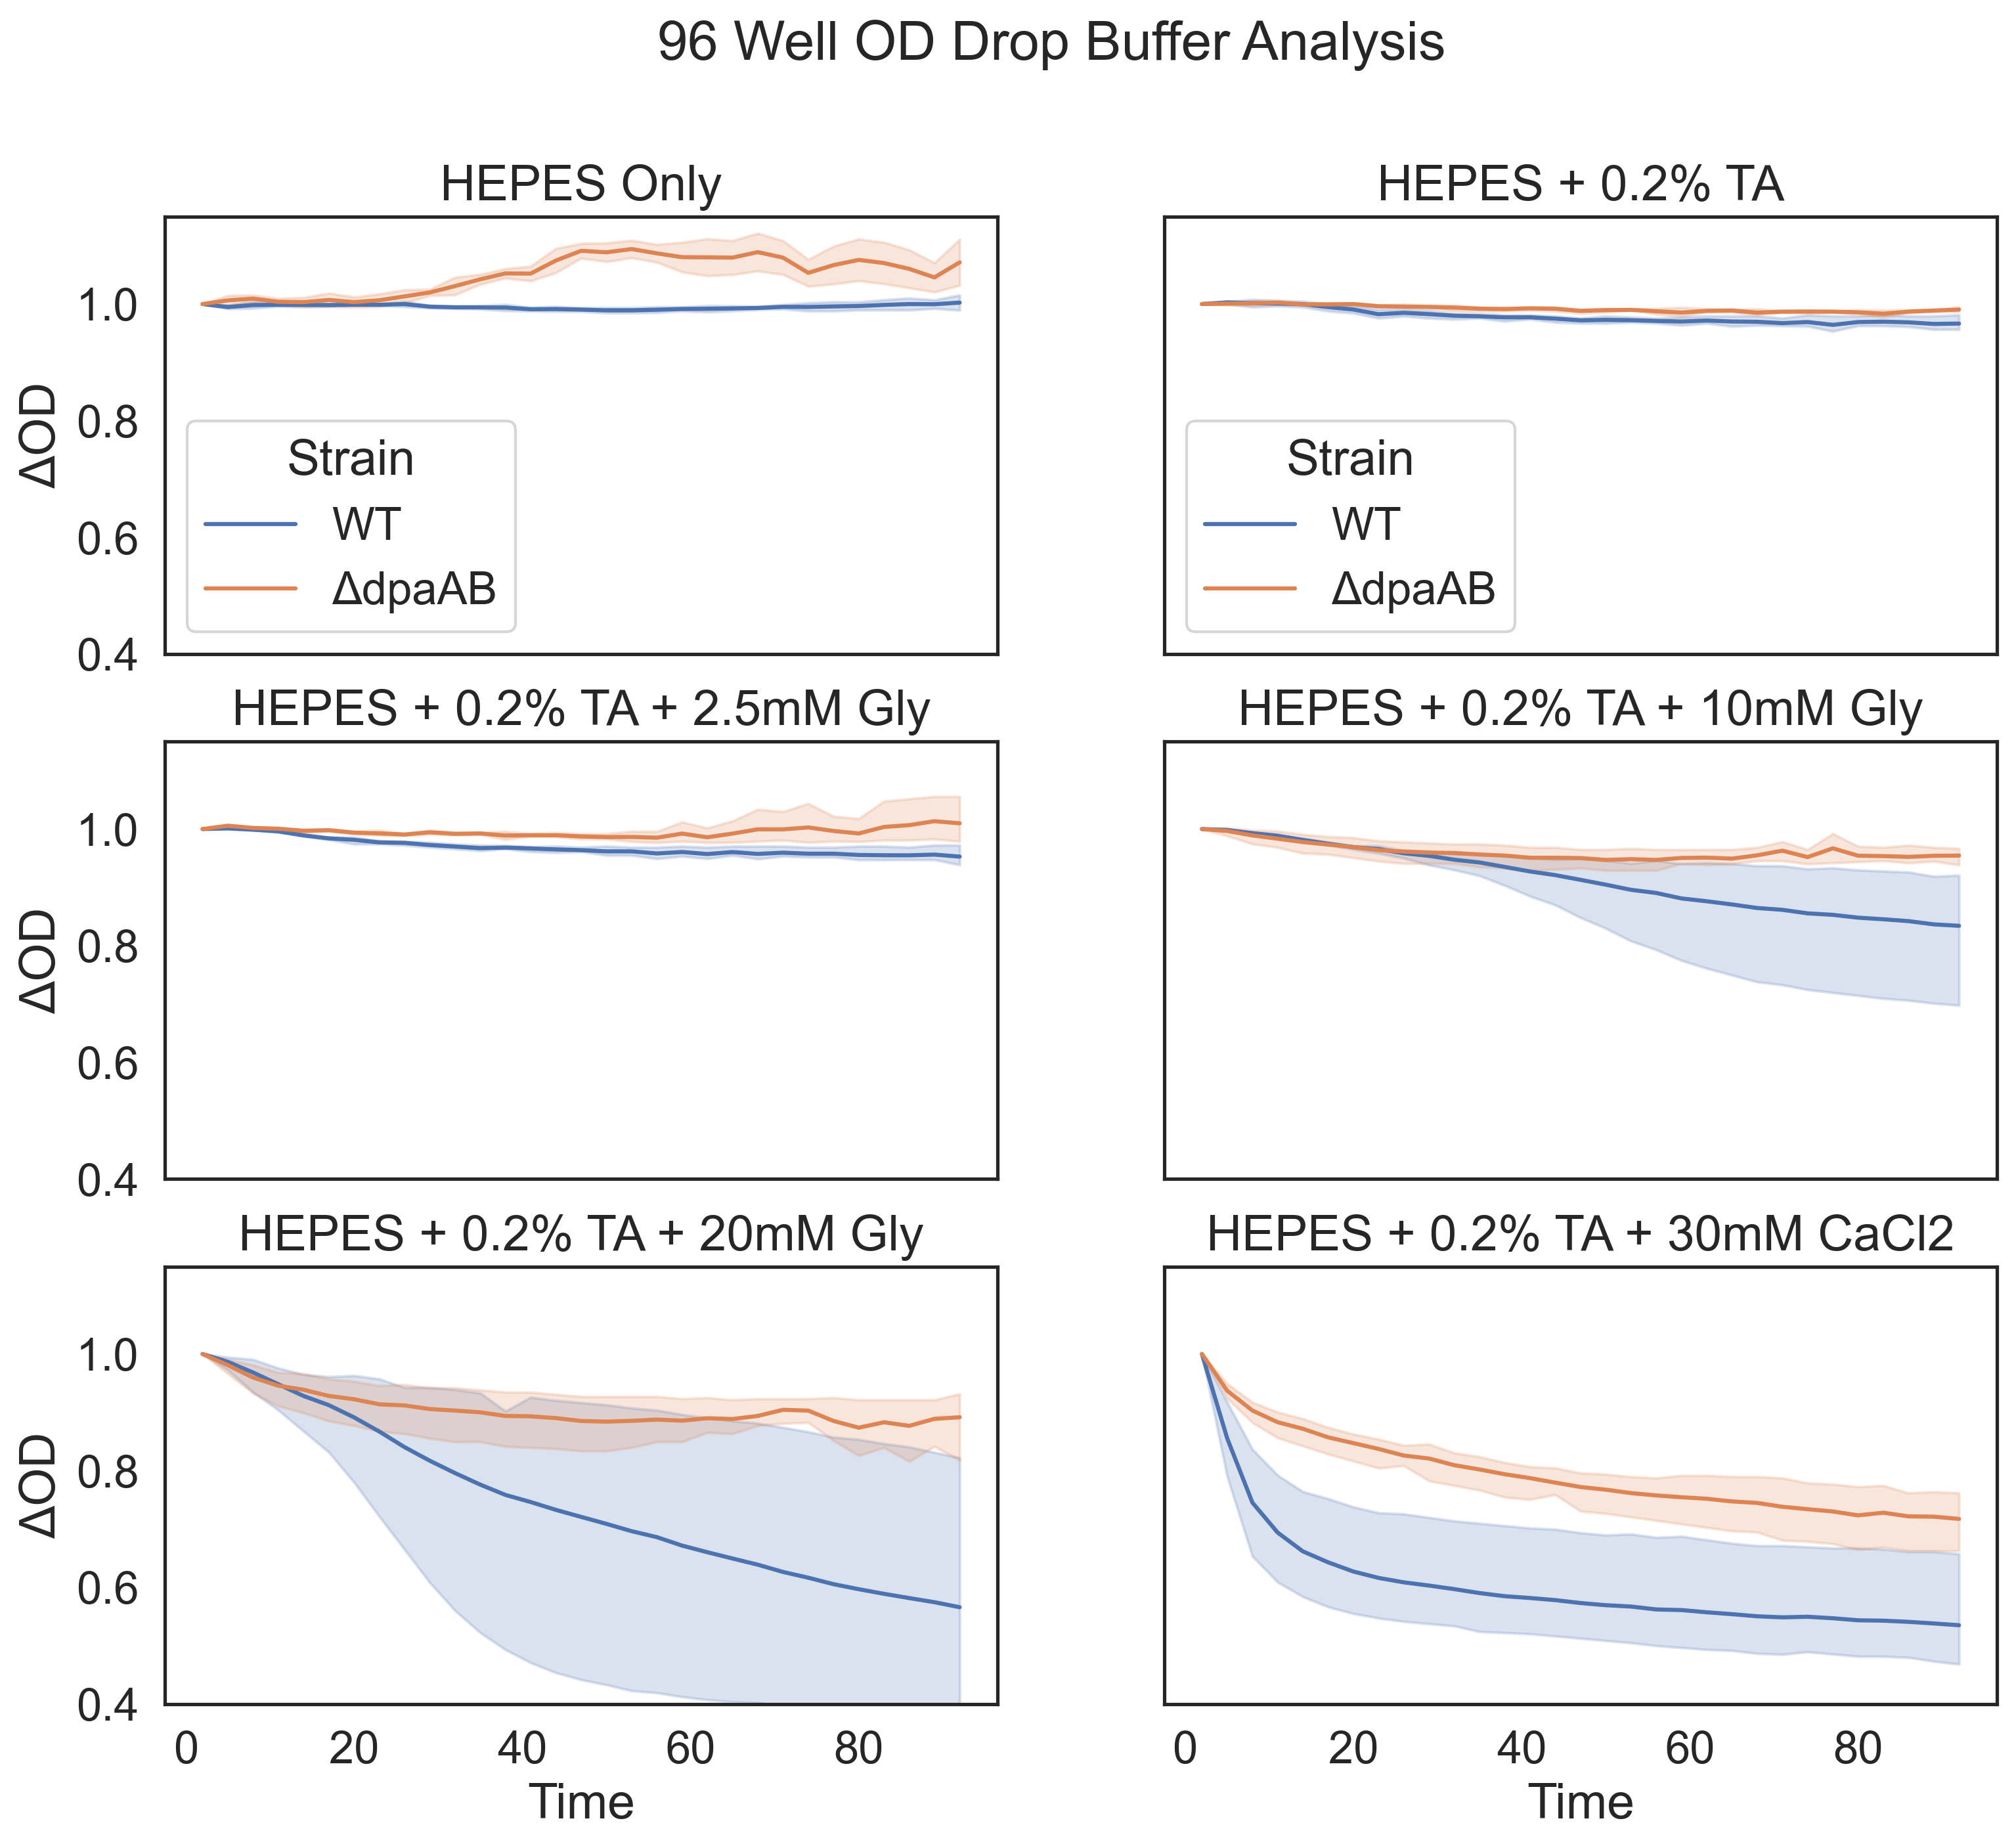

In [9]:
#Plot using seaborn
fig, ax = plt.subplots(3,2, sharey='row', sharex=True)

sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes Only'],x='Time',y='ΔOD', hue='Strain', ax=ax[0,0], errorbar='se')
sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes + 0.2% TA'],x='Time',y='ΔOD', hue='Strain', ax=ax[0,1])
sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes + 0.2% TA + 2.5mM Gly'],x='Time',y='ΔOD', hue='Strain', ax=ax[1,0])
sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes + 0.2% TA + 10mM Gly'],x='Time',y='ΔOD', hue='Strain', ax=ax[1,1])
sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes + 0.2% TA + 20mM Gly'],x='Time',y='ΔOD', hue='Strain', ax=ax[2,0])
sns.lineplot(data=od_bufferdat.loc[od_bufferdat.Condition == 'Hepes + 0.2% TA + 30mM CaCl2'],x='Time',y='ΔOD', hue='Strain', ax=ax[2,1])
fig.set_size_inches(12,10)
ax[0,0].set_title('HEPES Only')
ax[0,1].set_title('HEPES + 0.2% TA')
ax[1,0].set_title('HEPES + 0.2% TA + 2.5mM Gly')
ax[1,1].set_title('HEPES + 0.2% TA + 10mM Gly')
ax[2,0].set_title('HEPES + 0.2% TA + 20mM Gly')
ax[2,1].set_title('HEPES + 0.2% TA + 30mM CaCl2')

# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0.4, 1.15)

# Setting the values for all axes.
plt.setp(ax, ylim=custom_ylim)

ax[1,0].legend().set_visible(False)
ax[1,1].legend().set_visible(False)
ax[2,0].legend().set_visible(False)
ax[2,1].legend().set_visible(False)
fig.suptitle('96 Well OD Drop Buffer Analysis', fontsize=20)

# for ax in fig.axes:
#     ax.tick_params(labelrotation=60)
fig.savefig(os.path.join(figdir,'220929_96-well_OD_drop_buffers.svg'))

Define thresholds for germination and plot over time

In [26]:
#Get percent germination for single spore buffer analyses from normalized intesnity threshold.
thresh = 0.2
data_gly['germ_status']=0
data_gly.loc[data_gly.normint<=thresh,'germ_status'] = 1
pct_germ_glyca = data_gly.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count', 'sum']).reset_index()
pct_germ_glyca['pct_germ'] = (pct_germ_glyca['sum']/pct_germ_glyca['count'])*100

In [201]:
c1  = data_gly.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count'])

Strain        Condition  Replicate  Time  count
0            WT   10mM Gly 0% TA          1   2.5    237
1            WT   10mM Gly 0% TA          1   3.0    237
2            WT   10mM Gly 0% TA          1   3.5    237
3            WT   10mM Gly 0% TA          1   4.0    230
4            WT   10mM Gly 0% TA          1   4.5    237
...         ...              ...        ...   ...    ...
4315  del_dpaAB  30mM Ca 0.2% TA          3  90.0    173
4316  del_dpaAB  30mM Ca 0.2% TA          3  90.5    173
4317  del_dpaAB  30mM Ca 0.2% TA          3  91.0    173
4318  del_dpaAB  30mM Ca 0.2% TA          3  91.5    172
4319  del_dpaAB  30mM Ca 0.2% TA          3  92.0    175

[4320 rows x 5 columns]

In [204]:
c1.loc[c1.Time == c1.Time.min()]

Strain         Condition  Replicate  Time  count
0            WT    10mM Gly 0% TA          1   2.5    237
180          WT    10mM Gly 0% TA          2   2.5    234
360          WT    10mM Gly 0% TA          3   2.5    454
540          WT  10mM Gly 0.2% TA          1   2.5    203
720          WT  10mM Gly 0.2% TA          2   2.5    321
900          WT  10mM Gly 0.2% TA          3   2.5    191
1080         WT     30mM Ca 0% TA          1   2.5    456
1260         WT     30mM Ca 0% TA          2   2.5    340
1440         WT     30mM Ca 0% TA          3   2.5    122
1620         WT   30mM Ca 0.2% TA          1   2.5    316
1800         WT   30mM Ca 0.2% TA          2   2.5    221
1980         WT   30mM Ca 0.2% TA          3   2.5     72
2160  del_dpaAB    10mM Gly 0% TA          1   2.5    836
2340  del_dpaAB    10mM Gly 0% TA          2   2.5    608
2520  del_dpaAB    10mM Gly 0% TA          3   2.5     78
2700  del_dpaAB  10mM Gly 0.2% TA          1   2.5    454
2880  del_dpaAB  10mM Gly 0.2% TA          2   2.5    609
3060  del_dpaAB  10mM Gly 0.2% TA          3   2.5    472
3240  del_dpaAB     30mM Ca 0% TA          1   2.5    434
3420  del_dpaAB     30mM Ca 0% TA          2   2.5    294
3600  del_dpaAB     30mM Ca 0% TA          3   2.5    428
3780  del_dpaAB   30mM Ca 0.2% TA          1   2.5    746
3960  del_dpaAB   30mM Ca 0.2% TA          2   2.5    908
4140  del_dpaAB   30mM Ca 0.2% TA          3   2.5    195

In [27]:
#Make all lines the same color for single sporetraces
data_gly['tracecolor'] = '0.7'

In [28]:
#Generate subset to plot single traces.
num_samples = 50
subset = data_gly.groupby(['Strain','Condition'])['unique_id'].apply(lambda x: x.sample(num_samples, replace=True)).reset_index(name='subset_ids')
subset_ids = subset.subset_ids.to_numpy()
subdat = data_gly.loc[data_gly.unique_id.isin(subset_ids)]
subdat = subdat.loc[subdat.Time <= 30]

C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/3912334083.py:11: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=pct_germ_glyca.loc[pct_germ_glyca.Condition == '10mM Gly 0.2% TA'],x='Time',y='pct_germ', hue='Strain', ax=ax1, errorbar='se', linewidth=4, alpha=0.8, palette=palette)
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/3912334083.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=pct_germ_glyca.loc[pct_germ_glyca.Condition == '30mM Ca 0.2% TA'],x='Time',y='pct_germ', hue='Strain', ax=ax2, errorbar='se', linewidth=4, alpha=0.8, palette=palette)
c:\Users\shenlab\anaconda3\envs\pyspore_env\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\shenlab\anaconda3\envs\pyspore_env\l

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

30mM Ca 0.2% TA_WT vs. 30mM Ca 0.2% TA_del_dpaAB: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.953e-02 Stat=3.857e+00
10mM Gly 0.2% TA_WT vs. 10mM Gly 0.2% TA_del_dpaAB: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.953e-02 Stat=3.857e+00
10mM Gly 0.2% TA_WT vs. 30mM Ca 0.2% TA_WT: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.752e-01 Stat=1.190e+00
10mM Gly 0.2% TA_del_dpaAB vs. 30mM Ca 0.2% TA_del_dpaAB: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.266e-01 Stat=2.333e+00


C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/3912334083.py:118: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette, ax=ax4, errorbar='se', alpha=0.8, linewidth = 5)
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/3912334083.py:130: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette, ax=ax5, errorbar='se', alpha=0.8, linewidth = 5)
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/3912334083.py:141: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 

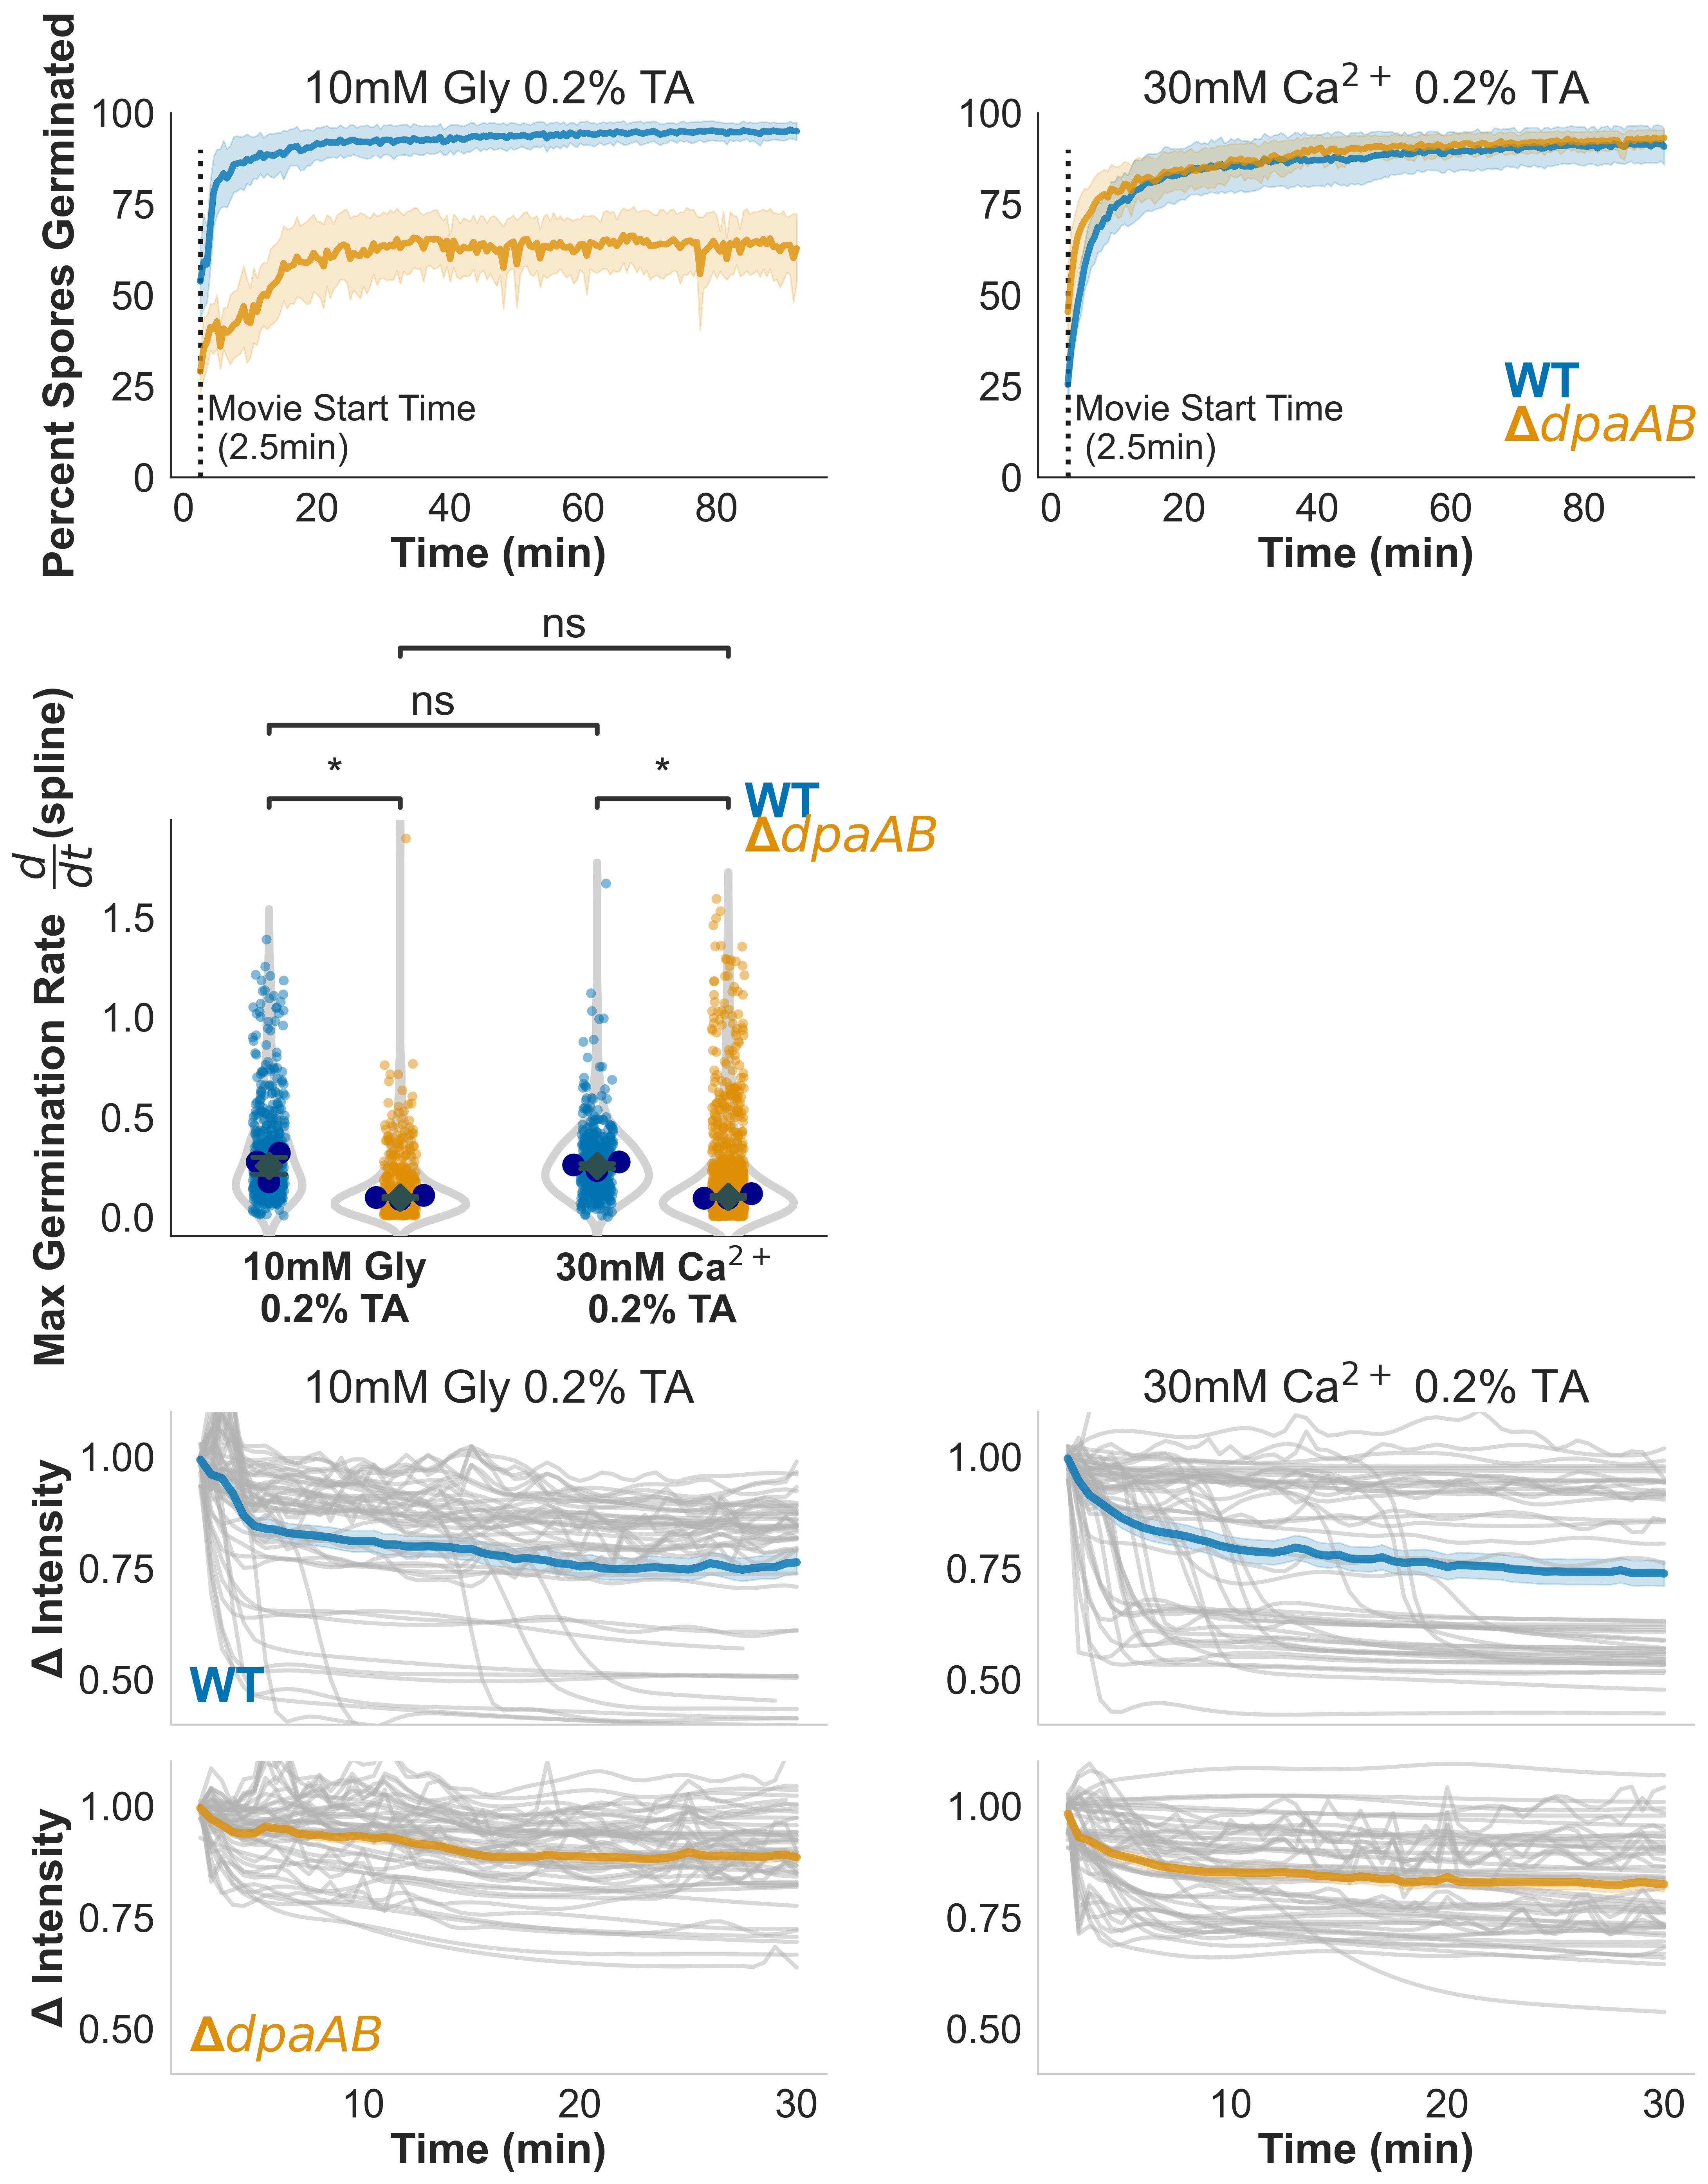

In [29]:
sns.set_theme(style="white", font_scale=2.2, font='arial')

palette = sns.color_palette('colorblind')

fig5 = plt.figure(figsize=(20,18), dpi=300, constrained_layout=True)

gs = fig5.add_gridspec(nrows=4, ncols=6, height_ratios=[1.75,2,1.5,1.5], hspace=0.07)
#plot germination over time for 10mM gly
ax1 = fig5.add_subplot(gs[0,:2])
ax1.set_title('10mM Gly 0.2% TA', size=28)
sns.lineplot(data=pct_germ_glyca.loc[pct_germ_glyca.Condition == '10mM Gly 0.2% TA'],x='Time',y='pct_germ', hue='Strain', ax=ax1, errorbar='se', linewidth=4, alpha=0.8, palette=palette)
ax1.set_ylim([0,100])
ax1.set_ylabel('Percent Spores Germinated', fontweight='bold')
ax1.set_xlabel('Time (min)', fontweight='bold')
ax1.legend().remove()
ax1.vlines(x=pct_germ_glyca.Time.min(), ymin=0, ymax=90, linestyles='dotted', colors='k', linewidth=3)
ax1.text(x=pct_germ_glyca.Time.min()+1, y=5, s='Movie Start Time \n (2.5min)', size=22)

#plot germination over time for 30mM Ca
ax2 = fig5.add_subplot(gs[0,2:4])
ax2.set_title('30mM Ca$^{2+}$ 0.2% TA', size=28)
sns.lineplot(data=pct_germ_glyca.loc[pct_germ_glyca.Condition == '30mM Ca 0.2% TA'],x='Time',y='pct_germ', hue='Strain', ax=ax2, errorbar='se', linewidth=4, alpha=0.8, palette=palette)
ax2.set_ylim([0,100])
ax2.set_ylabel('')
ax2.set_xlabel('Time (min)', fontweight='bold')
#ax2.legend(labels = ['WT', 'Δ$\it{dpaAB}$'], fontsize=25, frameon=False, loc='lower right')
ax2.legend().remove()
ax2.text(x=68, y=22, s='WT', fontsize=30, color=palette[0],fontweight='bold')
ax2.text(x=68, y=10, s='Δ$\it{dpaAB}$', fontsize=30, color=palette[1],fontweight='bold')
ax2.vlines(x=pct_germ_glyca.Time.min(), ymin=0, ymax=90, linestyles='dotted', colors='k', linewidth=3)
ax2.text(x=pct_germ_glyca.Time.min()+1, y=5, s='Movie Start Time \n (2.5min)', size=22)

#Populate superplot for germinattion rate into figure
rstats, ax3 = super_violins(data_gly_rt.loc[(data_gly_rt.Condition != '10mM Gly 0% TA')&(glydat_rt.Condition != '30mM Ca 0% TA')&(glydat_rt.max_germ_rate <2)],
                            'Condition','max_germ_rate','Strain','colorblind', 
                            size=(15,15), dpi=300, dodge=0.4, fig = fig5, gridspec=gs[1,:2], width=0.8, stat='median')
ax3.legend().remove()
ax3.set(xlabel='')
ax3.set_xticklabels(labels=['10mM Gly\n0.2% TA', '30mM Ca$^{2+}$\n0.2% TA'], size=24, fontweight='bold')
ax3.set_ylabel(ylabel=r'Max Germination Rate  $\dfrac{d}{dt}$(spline)', fontweight='bold')
#Put stats on plot
#set stats up
stats_args = {'test': 'Kruskal', 'loc': 'outside', 'line_width': 3}

colors = 'colorblind'

condition_order=['10mM Gly 0.2% TA', '30mM Ca 0.2% TA']
strain_order=['WT', 'del_dpaAB']
pairs = [(('10mM Gly 0.2% TA', 'WT'), ('10mM Gly 0.2% TA','del_dpaAB')),(('30mM Ca 0.2% TA', 'WT'), ('30mM Ca 0.2% TA','del_dpaAB')),
        (('10mM Gly 0.2% TA', 'WT'), ('30mM Ca 0.2% TA', 'WT')),(('10mM Gly 0.2% TA','del_dpaAB'), ('30mM Ca 0.2% TA','del_dpaAB'))]

annotator = Annotator(ax3, pairs, data = rstats, order = condition_order, hue_order=strain_order, hue='Strain', x = 'Condition', y = 'mean')
annotator.configure(**stats_args)
annotator.apply_and_annotate()
ax3.text(x=1.25, y=2, s='WT', fontsize=30, color=palette[0],fontweight='bold')
ax3.text(x=1.25, y=1.83, s='Δ$\it{dpaAB}$', fontsize=30, color=palette[1],fontweight='bold')


# #Make all lines the same color for single sporetraces
id_colors = ['0.7']*subdat.unique_id.nunique()
#Add plot for germination time
#Plot subset of spores
alpha = 0.5
linewidth = 2.5

# ax4 = fig5.add_subplot(gs[2,:2])
# ax4.set_title('10mM Gly 0.2% TA', size=28)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='normint', hue='unique_id', 
#              palette=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax4, errorbar='se', alpha=alpha, linewidth = linewidth)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='normint', hue='Condition', palette=palette, ax=ax4, errorbar='se', alpha=0.8, linewidth = 3)
# ax4.legend().remove()
# ax4.set_ylabel('Δ Intensity', fontweight='bold')
# ax4.set_xlabel('')
# ax4.set_xticklabels('')
# ax4.text(x=2, y=0.45, s='WT', fontsize=30, color=palette[0], fontweight='bold')
# ax4.set_ylim([0,1])

# ax5 = fig5.add_subplot(gs[2,2:4], sharey=ax4)
# ax5.set_title('30mM Ca$^{2+}$ 0.2% TA', size=28)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='normint', hue='unique_id', 
#              palette=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax5, errorbar='se', alpha=alpha, linewidth = linewidth)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='normint', hue='Condition', palette=palette, ax=ax5, errorbar='se', alpha=0.8, linewidth = 3)
# ax5.legend().remove()
# ax5.set_ylabel('')
# ax5.set_xlabel('')
# ax5.set_xticklabels('')
# ax5.set_ylim([0,1])

# ax6 = fig5.add_subplot(gs[3,:2])
# ax6.set_title('')
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='normint', hue='unique_id', 
#              palette=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax6, errorbar='se', alpha=alpha, linewidth = linewidth)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='normint', hue='Condition', palette=palette[1:], ax=ax6, errorbar='se', alpha=0.8, linewidth = 3)
# ax6.legend().remove()
# ax6.set_ylabel('Δ Intensity', fontweight='bold')
# ax6.text(x=2, y=0.45, s='Δ$\it{dpaAB}$', fontsize=30, color=palette[1],fontweight='bold')
# ax6.set_xlabel('Time (min)', fontweight='bold')
# ax6.set_ylim([0,1])

# ax7 = fig5.add_subplot(gs[3,2:4], sharey=ax6)
# ax7.set_title('')
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='normint', hue='unique_id', 
#              palette=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax7, errorbar='se', alpha=alpha, linewidth = linewidth)
# sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='normint', hue='Condition', palette=palette[1:], ax=ax7, errorbar='se', alpha=0.8, linewidth = 3)
# ax7.legend().remove()
# ax7.set_ylabel('')
# ax7.set_xlabel('Time (min)', fontweight='bold')
# ax7.set_ylim([0,1])

# for ax in fig5.axes:
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

ax4 = fig5.add_subplot(gs[2,:2])
ax4.set_title('10mM Gly 0.2% TA', size=28)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='Smoothed', hue='unique_id', 
             palette=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax4, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette, ax=ax4, errorbar='se', alpha=0.8, linewidth = 5)
ax4.legend().remove()
ax4.set_ylabel('Δ Intensity', fontweight='bold')
ax4.set_xlabel('')
ax4.set_xticklabels('')
ax4.text(x=2, y=0.45, s='WT', fontsize=30, color=palette[0], fontweight='bold')
ax4.set_ylim([0.4,1.1])

ax5 = fig5.add_subplot(gs[2,2:4], sharey=ax4)
ax5.set_title('30mM Ca$^{2+}$ 0.2% TA', size=28)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='Smoothed', hue='unique_id', 
             palette=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax5, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette, ax=ax5, errorbar='se', alpha=0.8, linewidth = 5)
ax5.legend().remove()
ax5.set_ylabel('')
ax5.set_xlabel('')
ax5.set_xticklabels('')
ax5.set_ylim([0.4,1.1])

ax6 = fig5.add_subplot(gs[3,:2])
ax6.set_title('')
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='Smoothed', hue='unique_id', 
             palette=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax6, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '10mM Gly 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette[1:], ax=ax6, errorbar='se', alpha=0.8, linewidth = 5)
ax6.legend().remove()
ax6.set_ylabel('Δ Intensity', fontweight='bold')
ax6.text(x=2, y=0.45, s='Δ$\it{dpaAB}$', fontsize=30, color=palette[1],fontweight='bold')
ax6.set_xlabel('Time (min)', fontweight='bold')
ax6.set_ylim([0.4,1.1])

ax7 = fig5.add_subplot(gs[3,2:4], sharey=ax6)
ax7.set_title('')
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='Smoothed', hue='unique_id', 
             palette=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA'), ['unique_id','tracecolor']].drop_duplicates().tracecolor.tolist(), ax=ax7, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_dpaAB') & (subdat.Condition== '30mM Ca 0.2% TA')], x='Time',y='Smoothed', hue='Condition', palette=palette[1:], ax=ax7, errorbar='se', alpha=0.8, linewidth = 5)
ax7.legend().remove()
ax7.set_ylabel('')
ax7.set_xlabel('Time (min)', fontweight='bold')
ax7.set_ylim([0.4,1.1])

for ax in fig5.axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [14]:
rstats

Strain  Replicate         Condition    median      mean  count
0          WT          1  10mM Gly 0.2% TA  0.320904  0.445313    107
1          WT          1   30mM Ca 0.2% TA  0.233508  0.268745    227
2          WT          2  10mM Gly 0.2% TA  0.276616  0.317598    212
3          WT          2   30mM Ca 0.2% TA  0.261502  0.278020    155
4          WT          3  10mM Gly 0.2% TA  0.176808  0.273746    151
5          WT          3   30mM Ca 0.2% TA  0.276436  0.309845     52
6   del_dpaAB          1  10mM Gly 0.2% TA  0.098769  0.118835     99
7   del_dpaAB          1   30mM Ca 0.2% TA  0.094994  0.195337    322
8   del_dpaAB          2  10mM Gly 0.2% TA  0.109464  0.183832    173
9   del_dpaAB          2   30mM Ca 0.2% TA  0.093932  0.226177    536
10  del_dpaAB          3  10mM Gly 0.2% TA  0.088766  0.122508    194
11  del_dpaAB          3   30mM Ca 0.2% TA  0.117967  0.148072    164

In [30]:
#Save figure to fig directory
fig5.savefig(os.path.join(figdir,'figure_5_singlespore_buffers.svg'))

Plot cortex PySpore validation data

In [25]:
# #get pecent germinated for cortex data
thresh = 0.12

data_cortex['germ_status'] = 0
data_cortex['Time'] = data_cortex['Time']+1
data_cortex.loc[data_cortex.normint <= thresh, 'germ_status'] = 1
pct_germ_corda = data_cortex.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count', 'sum']).reset_index()
pct_germ_corda['pct_germ'] = (pct_germ_corda['sum']/pct_germ_corda['count'])*100

In [26]:
c2  = data_cortex.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count']).reset_index()
c2.loc[c2.Time==c2.Time.min()]

Strain     Condition  Replicate  Time  count
0           WT  BHIS 0.5% TA          1   2.5    196
178         WT  BHIS 0.5% TA          2   2.5    110
356         WT  BHIS 0.5% TA          3   2.5    218
1062  del_cwlD  BHIS 0.5% TA          1   2.5    640
1240  del_cwlD  BHIS 0.5% TA          2   2.5    696
1418  del_cwlD  BHIS 0.5% TA          3   2.5    525
1596  del_pdaA  BHIS 0.5% TA          1   2.5    132
1774  del_pdaA  BHIS 0.5% TA          2   2.5    356
1952  del_pdaA  BHIS 0.5% TA          3   2.5    694

In [34]:
#Get subset of ALL spores for plotting single traces
#Generate subset to plot single traces
num_samples = 50
subset = data_cortex.groupby(['Strain'])['unique_id'].apply(lambda x: x.sample(num_samples, replace=True)).reset_index(name='subset_ids')
subset_ids = subset.subset_ids.to_numpy()
subdat = data_cortex.loc[data_cortex.unique_id.isin(subset_ids)]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. del_cwlD: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.953e-02 Stat=3.857e+00
del_cwlD vs. del_pdaA: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.953e-02 Stat=3.857e+00
WT vs. del_pdaA: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.953e-02 Stat=3.857e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. del_cwlD: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.630e-02 Stat=3.971e+00
del_cwlD vs. del_pdaA: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.127e-01 Stat=4.286e-01
WT vs. del_pdaA: Kruskal-Wallis independent samples (pairwise between groups

C:\Users\shenlab\AppData\Local\Temp/ipykernel_21972/2756316847.py:74: UserWarning: The palette list has more values (191) than needed (49), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT')], x='Time',y='Smoothed', hue='unique_id', ax=ax4, palette=id_colors, errorbar='se', alpha=alpha, linewidth = linewidth)
C:\Users\shenlab\AppData\Local\Temp/ipykernel_21972/2756316847.py:85: UserWarning: The palette list has more values (191) than needed (50), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_cwlD')], x='Time',y='Smoothed', hue='unique_id', palette=id_colors, ax=ax5, errorbar='se', alpha=alpha, linewidth = linewidth)
C:\Users\shenlab\AppData\Local\Temp/ipykernel_21972/2756316847.py:95: UserWarning: The palette list has more values (191) than needed (47), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_pdaA')], x='Time',y='Smoothed', hue='unique_id', palette=id_colors, ax=ax6, errorbar='se'

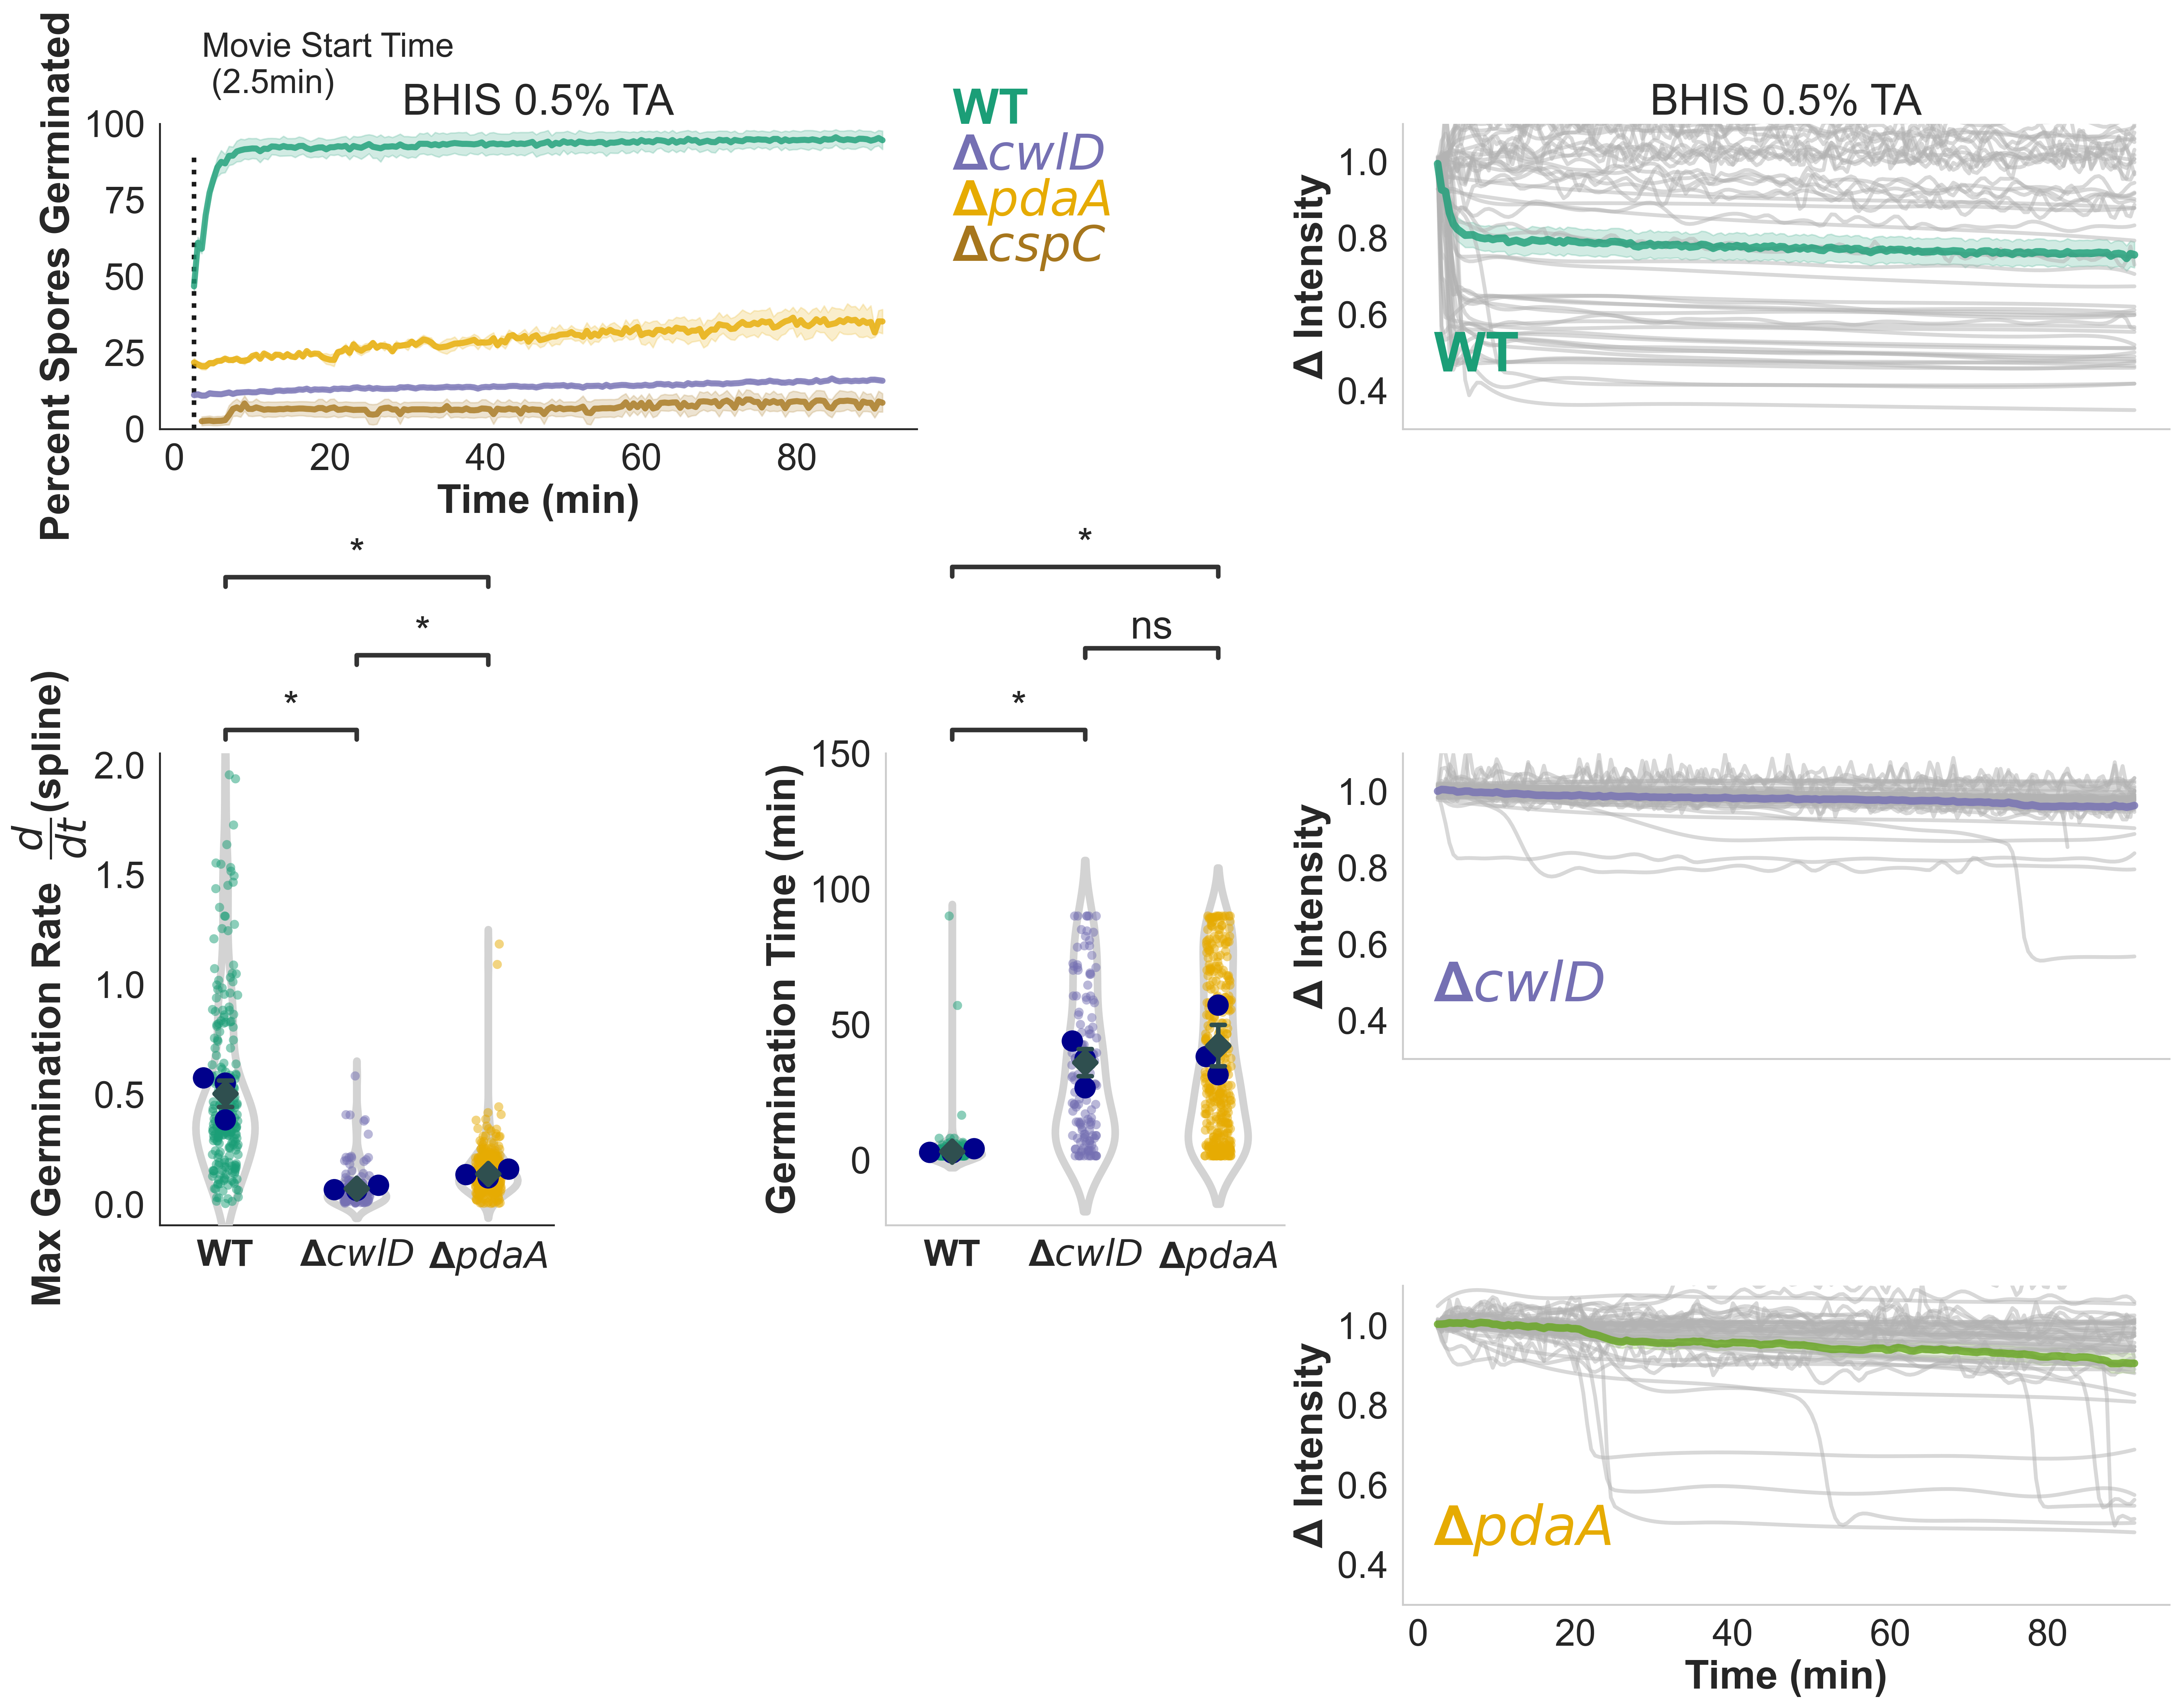

In [28]:
#Use a new color palette for these data
sns.set_theme(style="white", font_scale=2.2, font='arial')

palette = sns.color_palette('Dark2')

fig4 = plt.figure(figsize=(20,18), dpi=300, constrained_layout=True)

gs = fig4.add_gridspec(nrows=6, ncols=8, height_ratios=[1,1,0.5,0.5,0.5,1])

#plot germination over time for 10mM gly
ax1 = fig4.add_subplot(gs[0,1:4])
ax1.set_title('BHIS 0.5% TA', size=28)
sns.lineplot(data=pct_germ_corda,x='Time',y='pct_germ', hue='Strain', ax=ax1, errorbar='se', linewidth=4, alpha=0.8, palette=[palette[0], palette[6], palette[2], palette[5]])
ax1.set_ylim([0,100])
ax1.set_ylabel('Percent Spores Germinated', fontweight='bold')
ax1.set_xlabel('Time (min)', fontweight='bold')
ax1.legend().remove()
ax1.vlines(x=pct_germ_corda.Time.min(), ymin=0, ymax=90, linestyles='dotted', colors='k', linewidth=3)
ax1.text(x=pct_germ_corda.Time.min()+1, y=110, s=f'Movie Start Time \n ({pct_germ_corda.Time.min()}min)', size=22)
ax1.text(x=100, y=100, s='WT', fontsize=32, color=palette[0],fontweight='bold')
ax1.text(x=100, y=85, s='Δ$\it{cwlD}$', fontsize=32, color=palette[2],fontweight='bold')
ax1.text(x=100, y=70, s='Δ$\it{pdaA}$', fontsize=32, color=palette[5],fontweight='bold')
ax1.text(x=100, y=55, s='Δ$\it{cspC}$', fontsize=32, color=palette[6],fontweight='bold')

#Populate superplot for germinattion rate into figure
medians, ax2 = super_violins(data_cortex_rt.loc[(data_cortex_rt.Strain != 'del_cspC')&(data_cortex_rt.max_germ_rate < 3)],
                             'Strain','max_germ_rate','Strain',[palette[0], palette[2], palette[5]], 
                              size=(3,6), dpi=300, fig = fig4, gridspec=gs[1:3,1:3], width=0.45)
ax2.legend().remove()
ax2.set(xlabel='')
ax2.set_ylabel(ylabel=r'Max Germination Rate  $\dfrac{d}{dt}$(spline)', fontweight='bold')
ax2.set_xticklabels(labels=['WT', 'Δ$\it{cwlD}$', 'Δ$\it{pdaA}$'], size=24, fontweight='bold')
#set stats up
stats_args = {'test': 'Kruskal', 'loc': 'outside', 'line_width': 3}

comparisons = [('WT', 'del_cwlD'),('WT', 'del_pdaA'), ('del_cwlD', 'del_pdaA')]

order2 = ['WT','del_cwlD', 'del_pdaA']

annotator = Annotator(ax = ax2, order = order2, pairs = comparisons, data = medians, x = 'Strain', y = 'median')
annotator.configure(**stats_args)
annotator.apply_and_annotate()

#Populate superplot for germinattion times into figure
medians, ax3 = super_violins(data_cortex_rt.loc[(data_cortex_rt.Strain != 'del_cspC')],
                             'Strain','time_at_max','Strain',[palette[0], palette[2], palette[5]], 
                              size=(3,6), dpi=300, fig = fig4, gridspec=gs[1:3,3:5], width=0.45)
ax3.legend().remove()
ax3.set(xlabel='')
ax3.set_ylabel(ylabel=r'Germination Time (min)', fontweight='bold')
ax3.set_ylim([-24,150])
ax3.set_xticklabels(labels=['WT', 'Δ$\it{cwlD}$', 'Δ$\it{pdaA}$'], size=24, fontweight='bold')
#set stats up
stats_args = {'test': 'Kruskal', 'loc': 'outside', 'line_width': 3}

comparisons = [('WT', 'del_cwlD'),('WT', 'del_pdaA'), ('del_cwlD', 'del_pdaA')]

order2 = ['WT','del_cwlD', 'del_pdaA']

annotator = Annotator(ax = ax3, order = order2, pairs = comparisons, data = medians, x = 'Strain', y = 'median')
annotator.configure(**stats_args)
annotator.apply_and_annotate()



# #Make all lines the same color for single sporetraces
id_colors = ['0.7']*subdat.unique_id.nunique()
#Add plot for germination time
#Plot subset of spores
alpha = 0.5
linewidth = 2.5

ax4 = fig4.add_subplot(gs[0:1,5:8])
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT')], x='Time',y='Smoothed', hue='unique_id', ax=ax4, palette=id_colors, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'WT')], x='Time',y='Smoothed', hue='Condition', palette=[palette[0]], ax=ax4, errorbar='se', alpha=0.8, linewidth = 5)
ax4.legend().remove()
ax4.set_title('BHIS 0.5% TA', size=28)
ax4.set_ylabel('Δ Intensity', fontweight='bold')
ax4.set_xlabel('')
ax4.set_xticklabels('')
ax4.text(x=2, y=0.45, s='WT', fontsize=36, color=palette[0], fontweight='bold')
ax4.set_ylim([0.3,1.1])

ax5 = fig4.add_subplot(gs[1:2,5:8])
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_cwlD')], x='Time',y='Smoothed', hue='unique_id', palette=id_colors, ax=ax5, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_cwlD')], x='Time',y='Smoothed', hue='Condition', palette=[palette[2]], ax=ax5, errorbar='se', alpha=0.8, linewidth = 5)
ax5.legend().remove()
ax5.set_ylabel('Δ Intensity', fontweight='bold')
ax5.set_xlabel('')
ax5.set_xticklabels('')
ax5.text(x=2, y=0.45, s='Δ$\it{cwlD}$', fontsize=36, color=palette[2], fontweight='bold')
ax5.set_ylim([0.3,1.1])

ax6 = fig4.add_subplot(gs[3:5,5:8])
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_pdaA')], x='Time',y='Smoothed', hue='unique_id', palette=id_colors, ax=ax6, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Strain == 'del_pdaA')], x='Time',y='Smoothed', hue='Condition', palette=[palette[4]], ax=ax6, errorbar='se', alpha=0.8, linewidth = 5)
ax6.legend().remove()
ax6.set_ylabel('Δ Intensity', fontweight='bold')
ax6.set_xlabel('Time (min)', fontweight='bold')
ax6.text(x=2, y=0.45, s='Δ$\it{pdaA}$', fontsize=36, color=palette[5], fontweight='bold')
ax6.set_ylim([0.3,1.1])

for ax in fig4.axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

Plot out single spore analysis of Ca as a public good/ Can DPA be sensed for germination

In [29]:
#Save figure to fig directory
fig4.savefig(os.path.join(figdir,'cortex_muts_validation.svg'))

In [111]:
#get pecent germinated for supernatant data
thresh=0.15
data_sup['germ_status']=0
data_sup.loc[data_sup.normint<=thresh,'germ_status'] = 1
pct_germ_supda = data_sup.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count', 'sum']).reset_index()
pct_germ_supda['pct_germ'] = (pct_germ_supda['sum']/pct_germ_supda['count'])*100

In [187]:
counts = data_sup.groupby(['Condition'])['unique_id']

In [112]:
#Get subset of ALL spores for plotting single traces
#Generate subset to plot single traces
num_samples = 50
subset = data_sup.groupby(['Condition'])['unique_id'].apply(lambda x: x.sample(num_samples, replace=True)).reset_index(name='subset_ids')
subset_ids = subset.subset_ids.to_numpy()
subdat = data_sup.loc[data_sup.unique_id.isin(subset_ids)]

In [113]:
aggsupdat = data_sup_rt.groupby('Condition')['time_at_max'].agg(['median']).reset_index()

In [211]:
c3  = data_sup.groupby(['Strain', 'Condition', 'Replicate', 'Time'])['germ_status'].agg(['count']).reset_index()
c3.loc[c3.Time==c3.Time.min()]

Strain       Condition  Replicate  Time  count
0        WT            WTSN          1   6.5     93
180      WT            WTSN          2   6.5    158
360      WT            WTSN          3   6.5     94
540      WT         delABSN          1   6.5     61
708      WT         delABSN          2   6.5    189
888      WT         delABSN          3   6.5    586
1068     WT  delABSN_plusCa          1   6.5    237
1248     WT  delABSN_plusCa          2   6.5    363
1428     WT  delABSN_plusCa          3   6.5    432
1608     WT        germonly          1   6.5    182
1788     WT        germonly          2   6.5    209
1968     WT        germonly          3   6.5     49

In [115]:
med_germonly,med_wtsn, med_del_ABSN, med_del_ABSNCa = (aggsupdat.iloc[3,1],
                                                        aggsupdat.iloc[0,1],
                                                        aggsupdat.iloc[1,1],
                                                        aggsupdat.iloc[2,1])

C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/122850568.py:55: UserWarning: The palette list has more values (190) than needed (45), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Condition == 'germonly')], x='Time',y='Smoothed', hue='unique_id',
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/122850568.py:68: UserWarning: The palette list has more values (190) than needed (47), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Condition == 'WTSN')], x='Time',y='Smoothed', hue='unique_id',
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/122850568.py:80: UserWarning: The palette list has more values (190) than needed (49), which may not be intended.
  sns.lineplot(data=subdat.loc[(subdat.Condition == 'delABSN')], x='Time',y='Smoothed', hue='unique_id',
C:\Users\shenlab\AppData\Local\Temp/ipykernel_15660/122850568.py:92: UserWarning: The palette list has more values (190) than needed (49), which may not be intended.
  sns.lineplot(data=sub

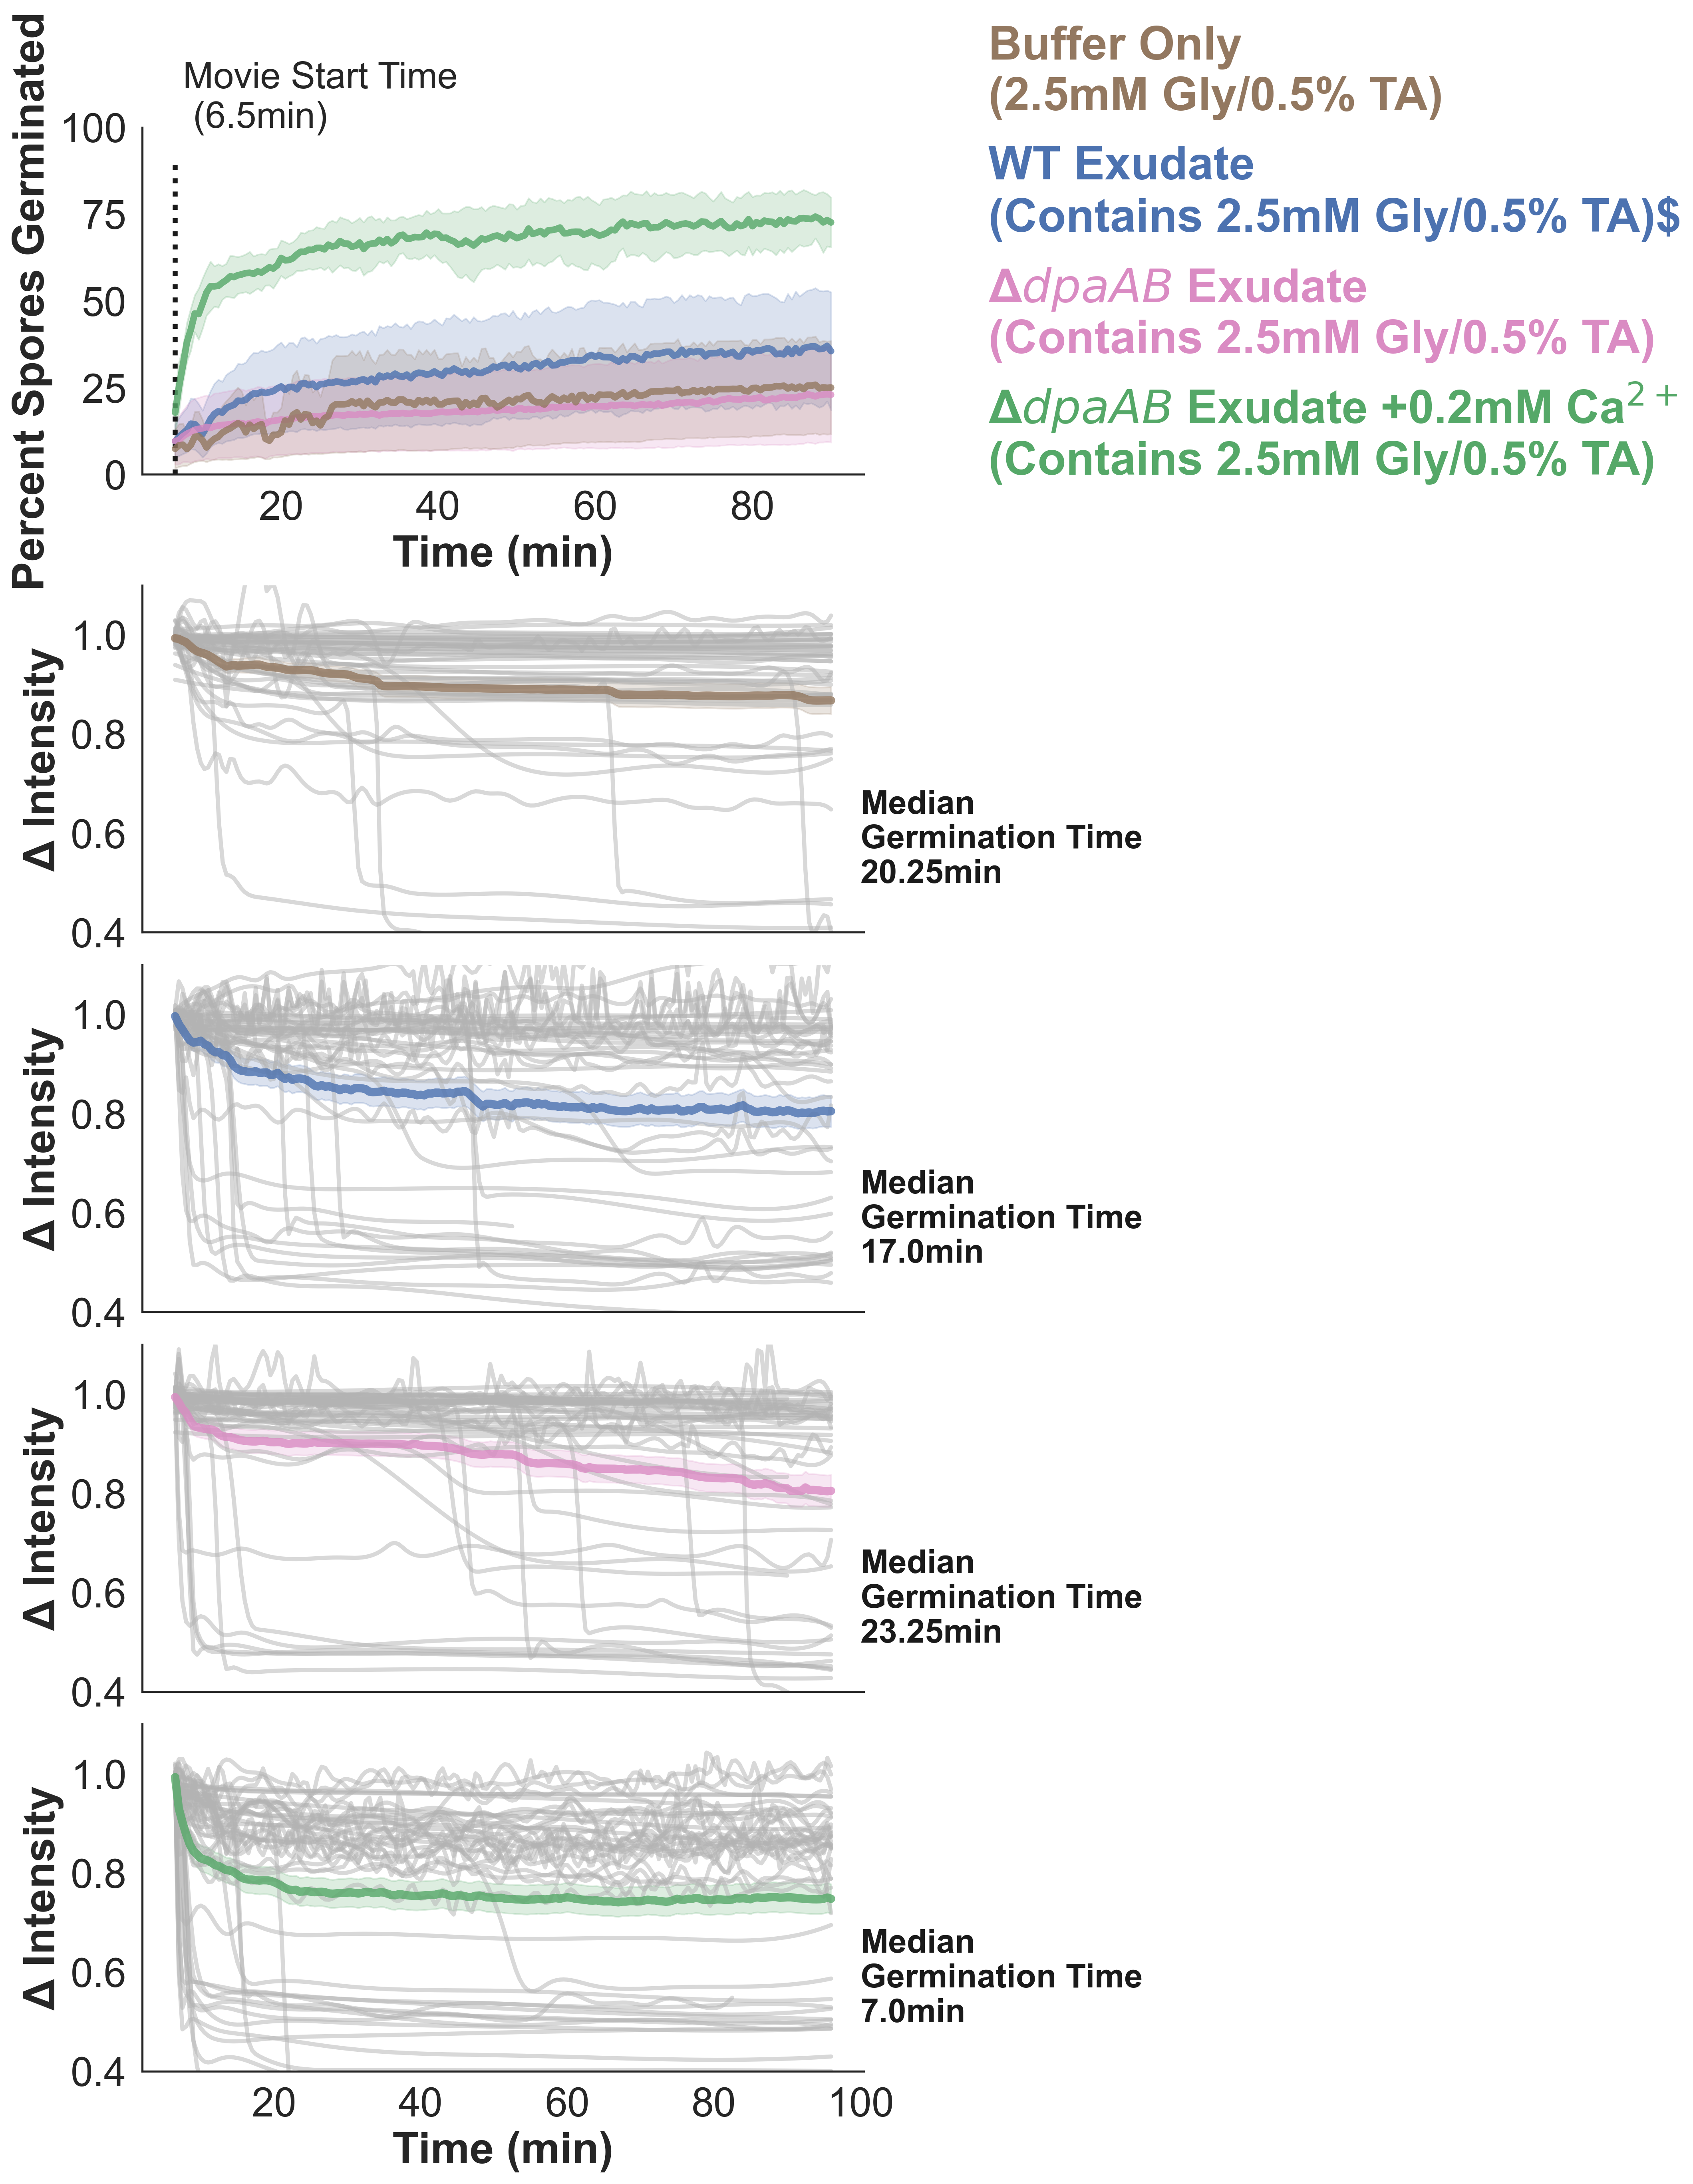

In [119]:
#Plot supernatant data
#Use a new color palette for these data
sns.set_theme(style="white", font_scale=2.2, font='arial')

palette = sns.color_palette('deep')

fig6 = plt.figure(figsize=(20,18), dpi=300, constrained_layout=True)

gs = fig6.add_gridspec(nrows=5, ncols=6)

#plot germination over time for 10mM gly
ax1 = fig6.add_subplot(gs[0,:3])
#ax1.set_title('BHIS 0.5% TA', size=28)
sns.lineplot(data=pct_germ_supda.loc[pct_germ_supda.Time<=90],x='Time',y='pct_germ', hue='Condition', ax=ax1, errorbar='se', linewidth=4, alpha=0.8, palette=[palette[0], palette[6], palette[2], palette[5]])
ax1.set_ylim([0,100])
ax1.set_ylabel('Percent Spores Germinated', fontweight='bold')
ax1.set_xlabel('Time (min)', fontweight='bold')
ax1.legend().remove()
ax1.vlines(x=pct_germ_supda.Time.min(), ymin=0, ymax=90, linestyles='dotted', colors='k', linewidth=3)
ax1.text(x=pct_germ_supda.Time.min()+1, y=100, s=f'Movie Start Time \n ({pct_germ_supda.Time.min()}min)', size=22)
ax1.text(x=110, y=105, s='Buffer Only\n(2.5mM Gly/0.5% TA)', fontsize=28, color=palette[5],fontweight='bold')
ax1.text(x=110, y=70, s='WT Exudate\n(Contains 2.5mM Gly/0.5% TA)$', fontsize=28, color=palette[0],fontweight='bold')
ax1.text(x=110, y=35, s='Δ$\it{dpaAB}$ Exudate\n(Contains 2.5mM Gly/0.5% TA)', fontsize=28, color=palette[6],fontweight='bold')
ax1.text(x=110, y=0, s='Δ$\it{dpaAB}$ Exudate +0.2mM Ca$^{2+}$\n(Contains 2.5mM Gly/0.5% TA)', fontsize=28, color=palette[2],fontweight='bold')

# #Populate superplot for germinattion times into figure
# medians, ax3 = super_violins(data_sup_rt,
#                              'Condition','time_at_max','Condition',[palette[5], palette[0], palette[6], palette[2]], 
#                               size=(3,6), dpi=300, fig = fig6, gridspec=gs[0,3:5], width=0.45)
# ax3.legend().remove()
# ax3.set(xlabel='')
# ax3.set_ylabel(ylabel=r'Germination Initiation Time (min)', fontweight='bold')
# ax3.set_ylim([-24,150])
# # ax3.set_xticklabels(labels=['WT', 'Δ$\it{cwlD}$', 'Δ$\it{pdaA}$'], size=24, fontweight='bold')
# #set stats up
# stats_args = {'test': 'Kruskal', 'loc': 'outside', 'line_width': 3}

# comparisons = [('WT', 'del_cwlD'),('WT', 'del_pdaA'), ('del_cwlD', 'del_pdaA')]

# order2 = ['WT','del_cwlD', 'del_pdaA']

# annotator = Annotator(ax = ax3, order = order2, pairs = comparisons, data = medians, x = 'Strain', y = 'median')
# annotator.configure(**stats_args)
# annotator.apply_and_annotate()


# #Make all lines the same color for single sporetraces
id_colors = ['0.7']*subdat.unique_id.nunique()
#Add plot for germination time
#Plot subset of spores
alpha = 0.5
linewidth = 2.5

ax2 = fig6.add_subplot(gs[1,:3])
sns.lineplot(data=subdat.loc[(subdat.Condition == 'germonly')], x='Time',y='Smoothed', hue='unique_id', 
             palette=id_colors, 
             ax=ax2, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Condition == 'germonly')], x='Time',y='Smoothed', hue='Condition', palette=[palette[5]], ax=ax2, errorbar='se', alpha=0.8, linewidth = 5)
ax2.legend().remove()
ax2.set_title('', size=28)
ax2.set_ylabel('Δ Intensity', fontweight='bold')
ax2.set_xlabel('')
ax2.set_xticklabels('')
ax2.text(x=100, y=0.5, s=f'Median\nGermination Time\n{med_germonly}min', fontsize=20, color='k', fontweight='bold')
ax2.set_ylim([0.4,1.1])

ax3 = fig6.add_subplot(gs[2,:3])
sns.lineplot(data=subdat.loc[(subdat.Condition == 'WTSN')], x='Time',y='Smoothed', hue='unique_id', 
             palette=id_colors, 
             ax=ax3, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Condition == 'WTSN')], x='Time',y='Smoothed', hue='Condition', palette=[palette[0]], ax=ax3, errorbar='se', alpha=0.8, linewidth = 5)
ax3.legend().remove()
ax3.set_ylabel('Δ Intensity', fontweight='bold')
ax3.set_xlabel('')
ax3.set_xticklabels('')
ax3.text(x=100, y=0.5, s=f'Median\nGermination Time\n{med_wtsn}min', fontsize=20, color='k', fontweight='bold')
ax3.set_ylim([0.4,1.1])

ax4 = fig6.add_subplot(gs[3,:3])
sns.lineplot(data=subdat.loc[(subdat.Condition == 'delABSN')], x='Time',y='Smoothed', hue='unique_id', 
             palette=id_colors, 
             ax=ax4, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Condition == 'delABSN')], x='Time',y='Smoothed', hue='Condition', palette=[palette[6]], ax=ax4, errorbar='se', alpha=0.8, linewidth = 5)
ax4.legend().remove()
ax4.set_ylabel('Δ Intensity', fontweight='bold')
ax4.set_xlabel('')
ax4.set_xticklabels('')
ax4.text(x=100, y=0.5, s=f'Median\nGermination Time\n{med_del_ABSN}min', fontsize=20, color='k', fontweight='bold')
ax4.set_ylim([0.4,1.1])

ax5 = fig6.add_subplot(gs[4,:3])
sns.lineplot(data=subdat.loc[(subdat.Condition == 'delABSN_plusCa')], x='Time',y='Smoothed', hue='unique_id', 
             palette=id_colors, 
             ax=ax5, errorbar='se', alpha=alpha, linewidth = linewidth)
sns.lineplot(data=subdat.loc[(subdat.Condition == 'delABSN_plusCa')], x='Time',y='Smoothed', hue='Condition', palette=[palette[2]], ax=ax5, errorbar='se', alpha=0.8, linewidth = 5)
ax5.legend().remove()
ax5.set_ylabel('Δ Intensity', fontweight='bold')
ax5.set_xlabel('Time (min)', fontweight='bold')
ax5.text(x=100, y=0.5, s=f'Median\nGermination Time\n{med_del_ABSNCa}min', fontsize=20, color='k', fontweight='bold')
ax5.set_ylim([0.4,1.1])
for ax in fig6.axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [120]:
#Save figure to fig directory
fig6.savefig(os.path.join(figdir,'exudate_analyses.svg'))